In [26]:
## according to cpuworld opteron 6272 is bulldozer cpu with '16' cores. That means only 8 fpu's and 16 alus represented as 16 cores.
## And the task use fpu. L2 cache is 'shared' per 2 ALU 1 FPU (1 block). L3 is shared. According to cpuworld 2x8mB L3 points to NUMA
## 4 + 4 blocks. The task uses memory much more than calculation (~128M for 64bit double). So optimal perf is predicted at 4 threads.
## And yes there is definite dip there.

import numpy as np
import subprocess
from mpl_toolkits import mplot3d
import ipympl
%matplotlib ipympl
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from tabulate import tabulate
from tqdm import tqdm

In [27]:
x_max = 5
t_max = 10
# 3d surface work properly only when x_points == t_points
x_points = 512
t_points = 512
n_proc = 6

plt_rcount = 128
plt_ccount = 128

t_points_at_x_var = 100
x_points_start = n_proc
x_points_end = 25000
x_var_step = 1000

x_points_at_t_var = 100
t_points_start = 10
t_points_end = 25000
t_var_step = 1000

np_start = 1
np_end = 6
t_points_at_np_var = 4096
x_points_at_np_var = 4096

  rank    calc time    gather time    total time
------  -----------  -------------  ------------
     0   0.00297432    0.00204494     0.10245
     1   0.00299263    0.000884889    0.00388267
     2   0.00305569    0.00111131     0.00439418
     3   0.00302641    0.00132657     0.00435867
     4   0.00302462    0.00156317     0.00488476
     5   0.00302268    0.00185073     0.00488193


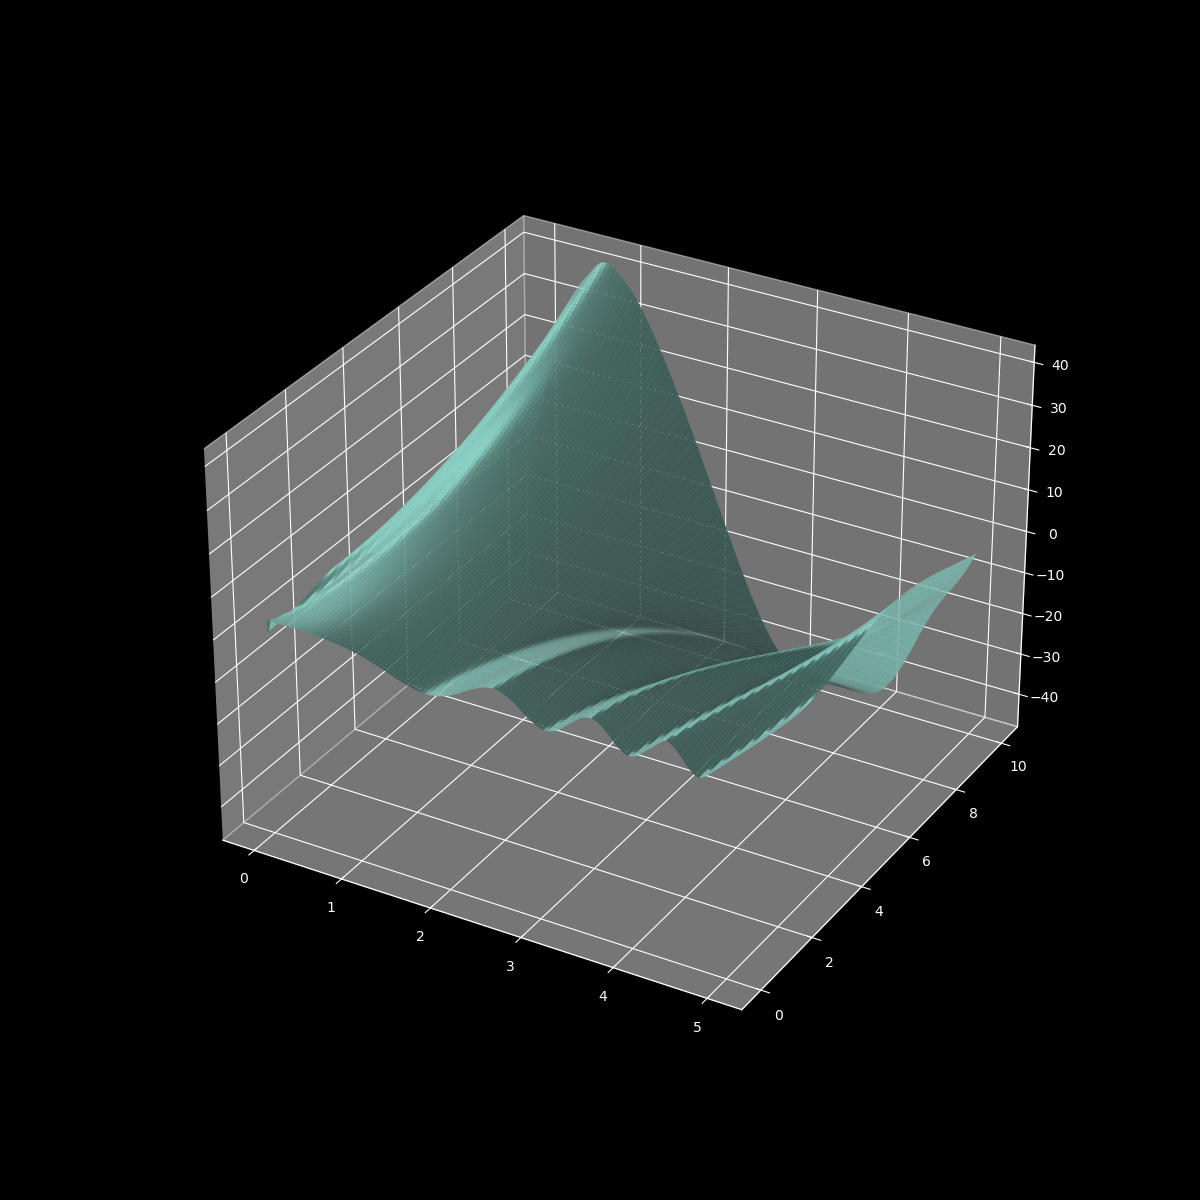

In [28]:
matrix = np.zeros ((x_points, x_points))
perf_ranks = np.zeros ((n_proc, 3))
result = subprocess.run (["mpirun", "-np", "{0}".format (n_proc), "./transfer", "{0}".format (x_points), "{0}".format (t_points), "{0}".format (x_max), "{0}".format (t_max), "{0}".format (t_points - x_points), "{0}".format (t_points)], capture_output=True, text=True)
res_split = result.stdout.split ()
for i in range (0, x_points):
    for j in range (0, x_points):
        matrix[i][j] = res_split[i * x_points + j]
for i in range (0, n_proc):
    rank = res_split[x_points * x_points + i * 4]
    for j in range (0, 3):
        perf_ranks[int (rank)][j] = res_split[x_points * x_points + i * 4 + j + 1]
#print ("last layer :")
#print (matrix[x_points - 1])

tabledata = []
for i in range (0, n_proc):
    temp = []
    temp.append (i)
    temp.append (perf_ranks[i][0])
    temp.append (perf_ranks[i][1])
    temp.append (perf_ranks[i][2])
    tabledata.append (temp)
print (tabulate (tabledata, headers = ["rank", "calc time", "gather time", "total time"]))

X = np.outer (np.linspace (0, x_max, x_points), np.ones (x_points)).copy().T
T = np.outer (np.linspace (0, t_max, x_points), np.ones (x_points))
plt.figure(figsize=(12, 12))
plt.axes(projection ='3d').plot_surface (X, T, matrix, rcount = plt_rcount, ccount = plt_ccount)

100%|██████████| 25/25 [00:03<00:00,  8.03it/s]

  x_points    max calc time    max gather time    max total time
----------  ---------------  -----------------  ----------------
         6      0.000334664        0.000162522       0.000353655
      1006      0.00106565         0.000914293       0.00192486
      2006      0.00185866         0.00181799        0.00356219
      3006      0.00190991         0.00187793        0.00373066
      4006      0.00375612         0.00300506        0.00658599
      5006      0.00466908         0.00313637        0.00766414
      6006      0.00535995         0.00485659        0.00994894
      7006      0.00638749         0.00411773        0.0102637
      8006      0.0075638          0.00666179        0.0139969
      9006      0.00840371         0.00640035        0.014566
     10006      0.00877964         0.00592765        0.014408
     11006      0.0100564          0.00868677        0.01817
     12006      0.0100315          0.00760169        0.0175674
     13006      0.0114232          0.0084607   

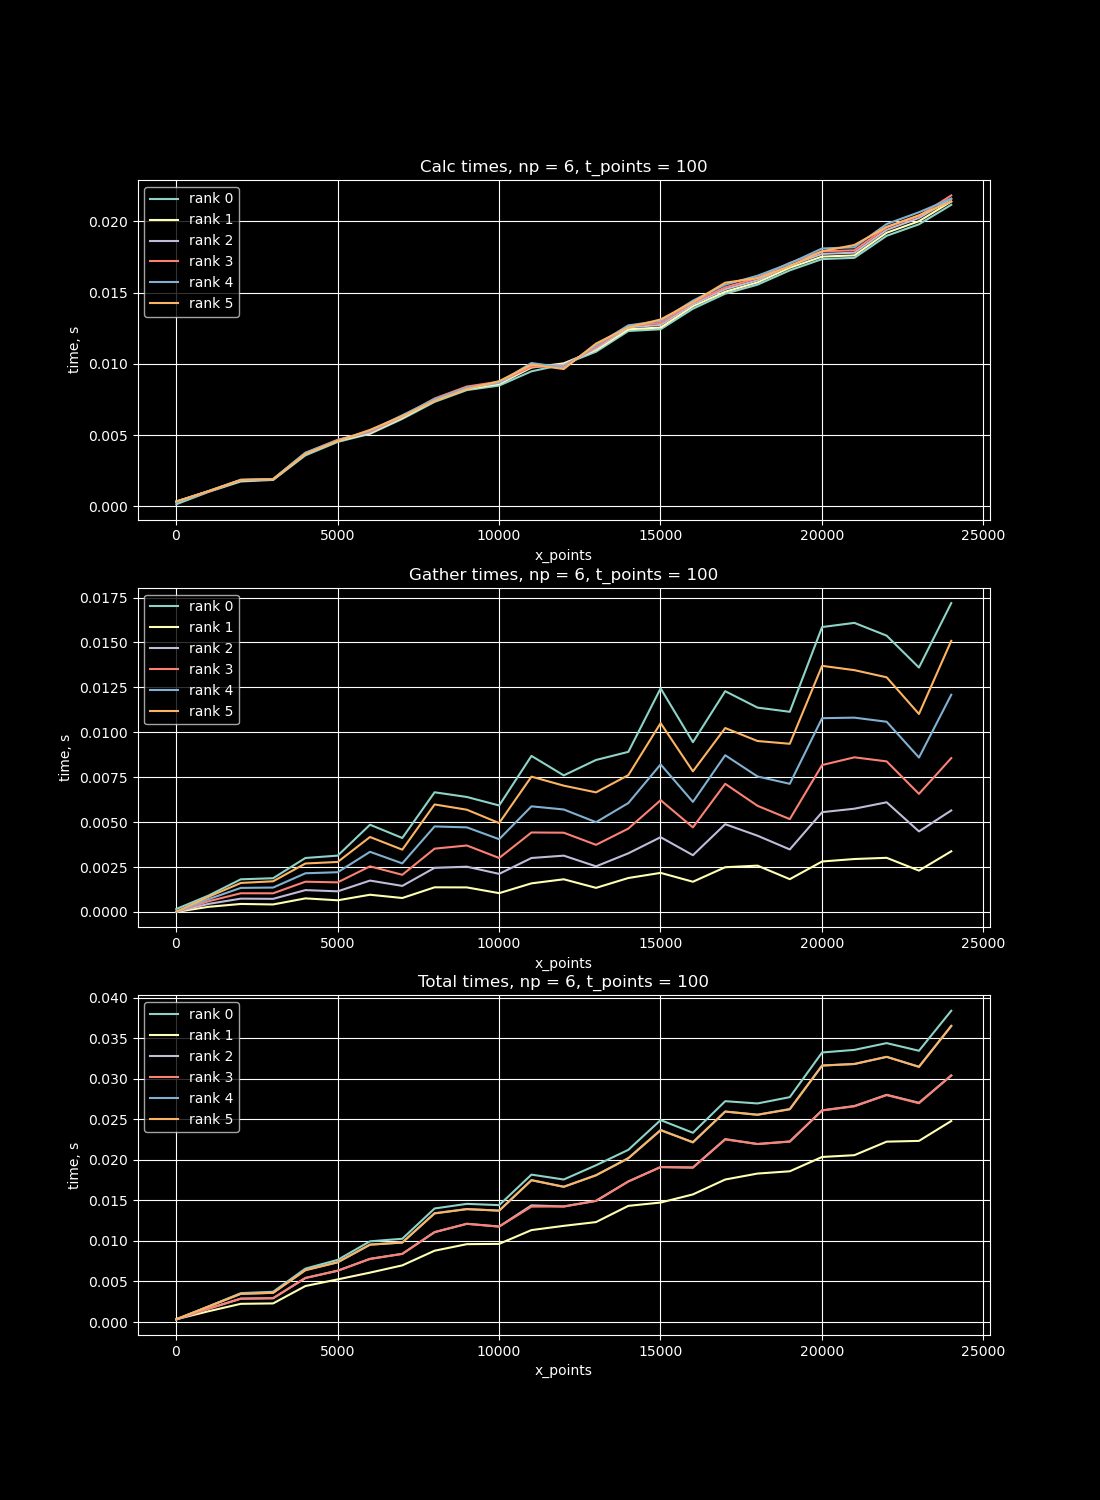

In [29]:
### x_points var at host
x_points_var = np.zeros (int ((x_points_end - x_points_start) / x_var_step) + 1)
times = np.zeros ((3, n_proc, int ((x_points_end - x_points_start) / x_var_step) + 1))
i = x_points_start
k = 0
tabledata = []
with tqdm(total=int ((x_points_end - x_points_start) / x_var_step) + 1) as pbar:
    while i < x_points_end:
        result = subprocess.run (["mpirun", "-np", "{0}".format (n_proc), "./transfer", "{0}".format (i), "{0}".format (t_points_at_x_var), "{0}".format (x_max), "{0}".format (t_max), "n"], capture_output=True, text=True)
        res_split = result.stdout.split ()
        times_max = np.zeros (3)
        for p in range (0, n_proc):
            rank = int (res_split[p * 4])
            for j in range (0, 3):
                times[j][rank][k] = res_split[p * 4 + j + 1]
                if times[j][rank][k] > times_max[j]:
                    times_max[j] = times[j][rank][k]
        x_points_var[k] = i
        temp = []
        temp.append (i)
        temp.append (times_max[0])
        temp.append (times_max[1])
        temp.append (times_max[2])
        tabledata.append (temp)
        i = i + x_var_step
        k = k + 1
        pbar.update (1)

print (tabulate (tabledata, headers = ["x_points", "max calc time", "max gather time", "max total time"]))

plt.figure (figsize = [11, 15])

plt.subplot (311)
plt.grid ()
plt.title ("Calc times, np = {0}, t_points = {1}".format(n_proc, t_points_at_x_var))
plt.xlabel ("x_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (x_points_var, times[0][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (312)
plt.grid ()
plt.title ("Gather times, np = {0}, t_points = {1}".format(n_proc, t_points_at_x_var))
plt.xlabel ("x_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (x_points_var, times[1][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (313)
plt.grid ()
plt.title ("Total times, np = {0}, t_points = {1}".format(n_proc, t_points_at_x_var))
plt.xlabel ("x_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (x_points_var, times[2][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

100%|██████████| 25/25 [00:03<00:00,  7.28it/s]

  t_points    max calc time    max gather time    max total time
----------  ---------------  -----------------  ----------------
        10      0.000144851         3.847e-05        0.000188801
      1010      0.00201668          0.00108562       0.00309018
      2010      0.00360928          0.00161894       0.00522673
      3010      0.00599362          0.00195379       0.00792532
      4010      0.00819884          0.00306983       0.011279
      5010      0.0116494           0.00402666       0.0156583
      6010      0.0118772           0.00406544       0.0159296
      7010      0.0131275           0.00440785       0.0175292
      8010      0.0156918           0.00652879       0.0222072
      9010      0.0178125           0.0061613        0.0238436
     10010      0.0192554           0.00819039       0.0274291
     11010      0.0220436           0.00654606       0.0285692
     12010      0.0225948           0.00738434       0.0299973
     13010      0.0254439           0.0105341  

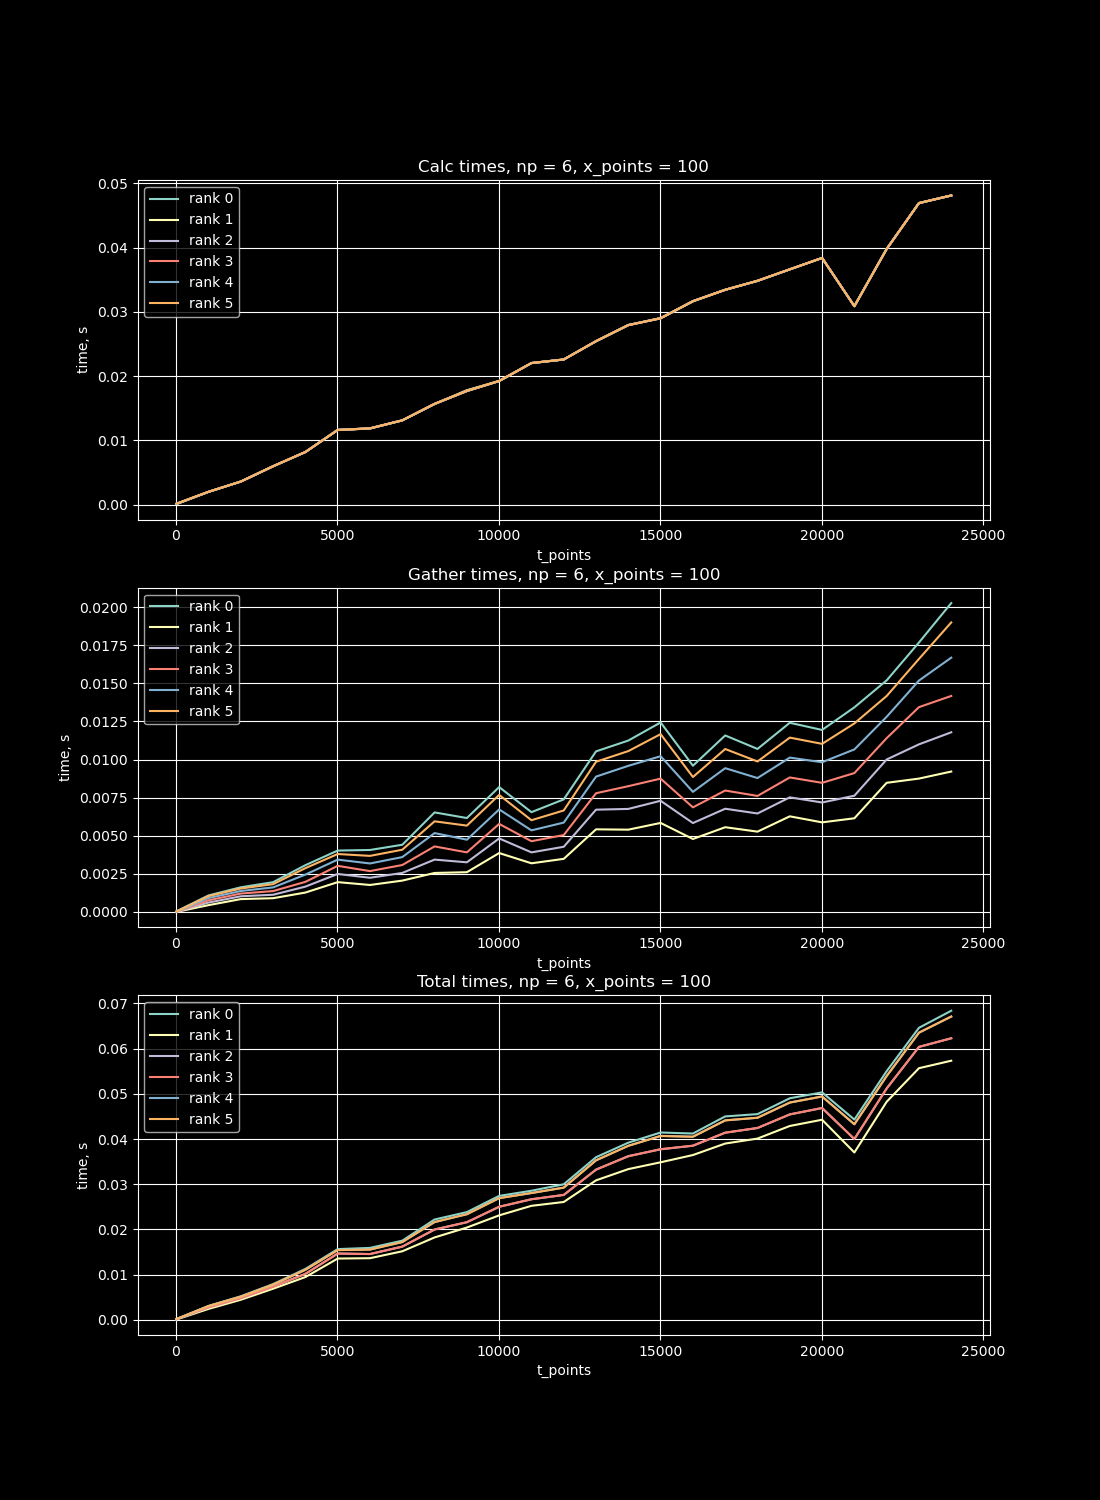

In [31]:
### t_points var at host
t_points_var = np.zeros (int ((t_points_end - t_points_start) / t_var_step) + 1)
times = np.zeros ((3, n_proc, int ((t_points_end - t_points_start) / t_var_step) + 1))
i = t_points_start
k = 0
tabledata = []
with tqdm (total = int ((t_points_end - t_points_start) / t_var_step) + 1) as pbar:
    while i < t_points_end:
        result = subprocess.run (["mpirun", "-np", "{0}".format (n_proc), "./transfer", "{0}".format (x_points_at_t_var), "{0}".format (i), "{0}".format (x_max), "{0}".format (t_max), "n"], capture_output=True, text=True)
        res_split = result.stdout.split ()
        times_max = np.zeros (3)
        for p in range (0, n_proc):
            rank = int (res_split[p * 4])
            for j in range (0, 3):
                times[j][rank][k] = res_split[p * 4 + j + 1]
                if times[j][rank][k] > times_max[j]:
                    times_max[j] = times[j][rank][k]
        t_points_var[k] = i
        temp = []
        temp.append (i)
        temp.append (times_max[0])
        temp.append (times_max[1])
        temp.append (times_max[2])
        tabledata.append (temp)
        i = i + t_var_step
        k = k + 1
        pbar.update (1)

print (tabulate (tabledata, headers = ["t_points", "max calc time", "max gather time", "max total time"]))

plt.figure (figsize = [11, 15])

plt.subplot (311)
plt.grid ()
plt.title ("Calc times, np = {0}, x_points = {1}".format(n_proc, x_points_at_t_var))
plt.xlabel ("t_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (t_points_var, times[0][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (312)
plt.grid ()
plt.title ("Gather times, np = {0}, x_points = {1}".format(n_proc, x_points_at_t_var))
plt.xlabel ("t_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (t_points_var, times[1][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (313)
plt.grid ()
plt.title ("Total times, np = {0}, x_points = {1}".format(n_proc, x_points_at_t_var))
plt.xlabel ("t_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (t_points_var, times[2][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

100%|██████████| 6/6 [00:02<00:00,  2.06it/s]

  N proc    max calc time    max gather time    max total time
--------  ---------------  -----------------  ----------------
       1         0.562681          4.8e-08            0.562699
       2         0.305381          0.096367           0.401713
       3         0.213957          0.100156           0.314129
       4         0.174824          0.0988103          0.27346
       5         0.167608          0.104488           0.272036
       6         0.157372          0.105235           0.26248


<StemContainer object of 3 artists>

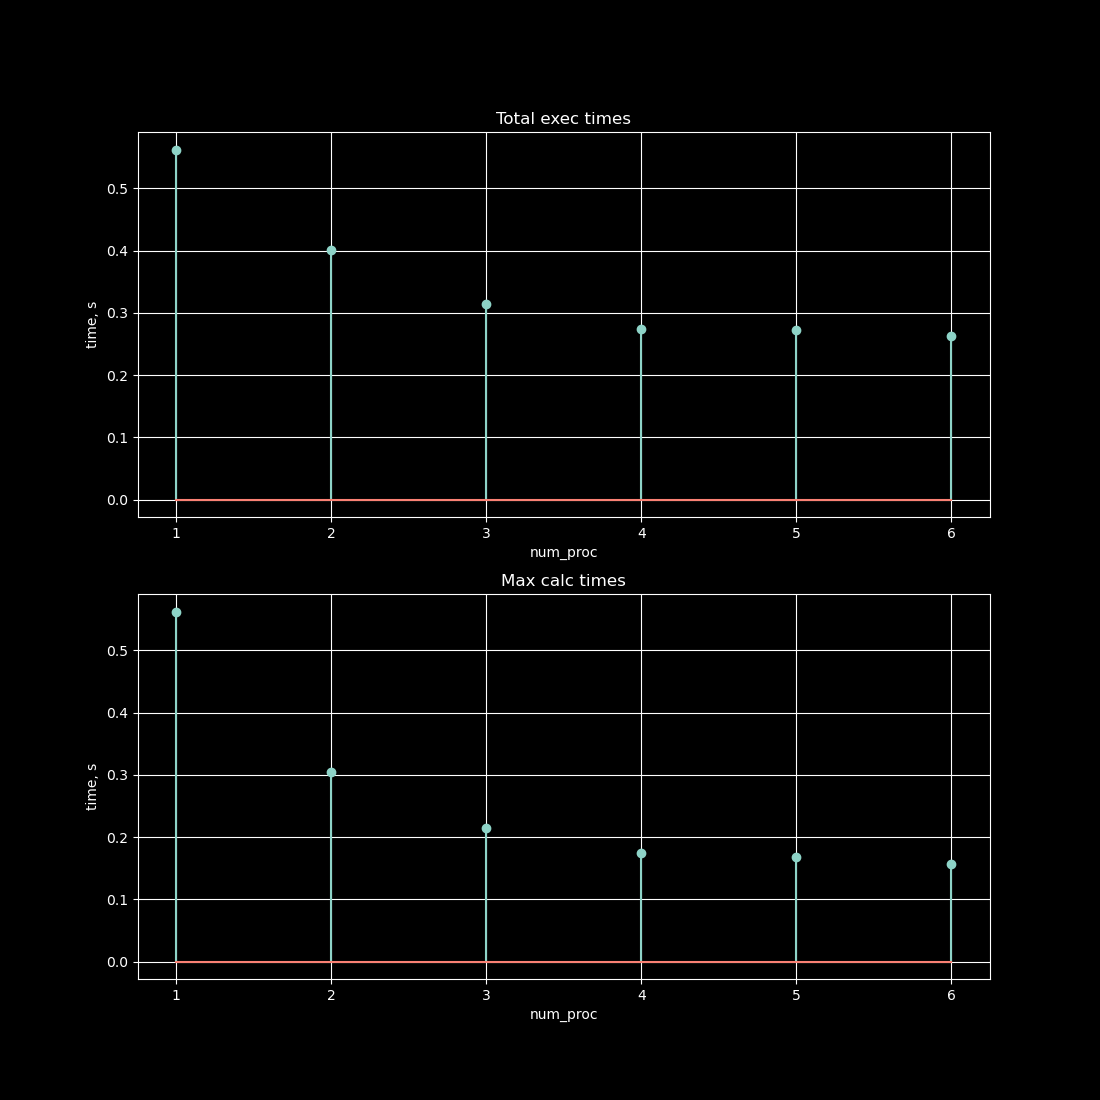

In [32]:
### np var at host

np_var = np.arange (np_start, np_end + 1)
times = np.zeros ((3, np_end - np_start + 1))
i = np_start
tabledata = []
with tqdm (total = np_end - np_start + 1) as pbar:
    while i <= np_end:
        result = subprocess.run (["mpirun", "-np", "{0}".format (i), "./transfer", "{0}".format (x_points_at_np_var), "{0}".format (t_points_at_np_var), "{0}".format (x_max), "{0}".format (t_max), "n"], capture_output=True, text=True)
        res_split = result.stdout.split ()
        max_calc = 0
        max_gather = 0
        max_total = 0
        for p in range (0, i - np_start + 1):
            if float (res_split[p * 4 + 1]) > max_calc:
                max_calc = float (res_split[p * 4 + 1])
            if float (res_split[p * 4 + 2]) > max_gather:
                max_gather = float (res_split[p * 4 + 2])
            if float (res_split[p * 4 + 3]) > max_total:
                max_total = float (res_split[p * 4 + 3])

        times[0][i - np_start] = max_calc
        times[1][i - np_start] = max_gather
        times[2][i - np_start] = max_total
        temp = []
        temp.append (i)
        temp.append (max_calc)
        temp.append (max_gather)
        temp.append (max_total)
        tabledata.append (temp)
        i = i + 1
        pbar.update (1)

print (tabulate (tabledata, headers = ["N proc", "max calc time", "max gather time", "max total time"]))

plt.figure (figsize = [11, 11])

plt.subplot (211)
plt.grid ()
plt.title ("Total exec times")
plt.xlabel ("num_proc")
plt.ylabel ("time, s")
plt.stem (np_var, times[2])

plt.subplot (212)
plt.grid ()
plt.title ("Max calc times")
plt.xlabel ("num_proc")
plt.ylabel ("time, s")
plt.stem (np_var, times[0])

<StemContainer object of 3 artists>

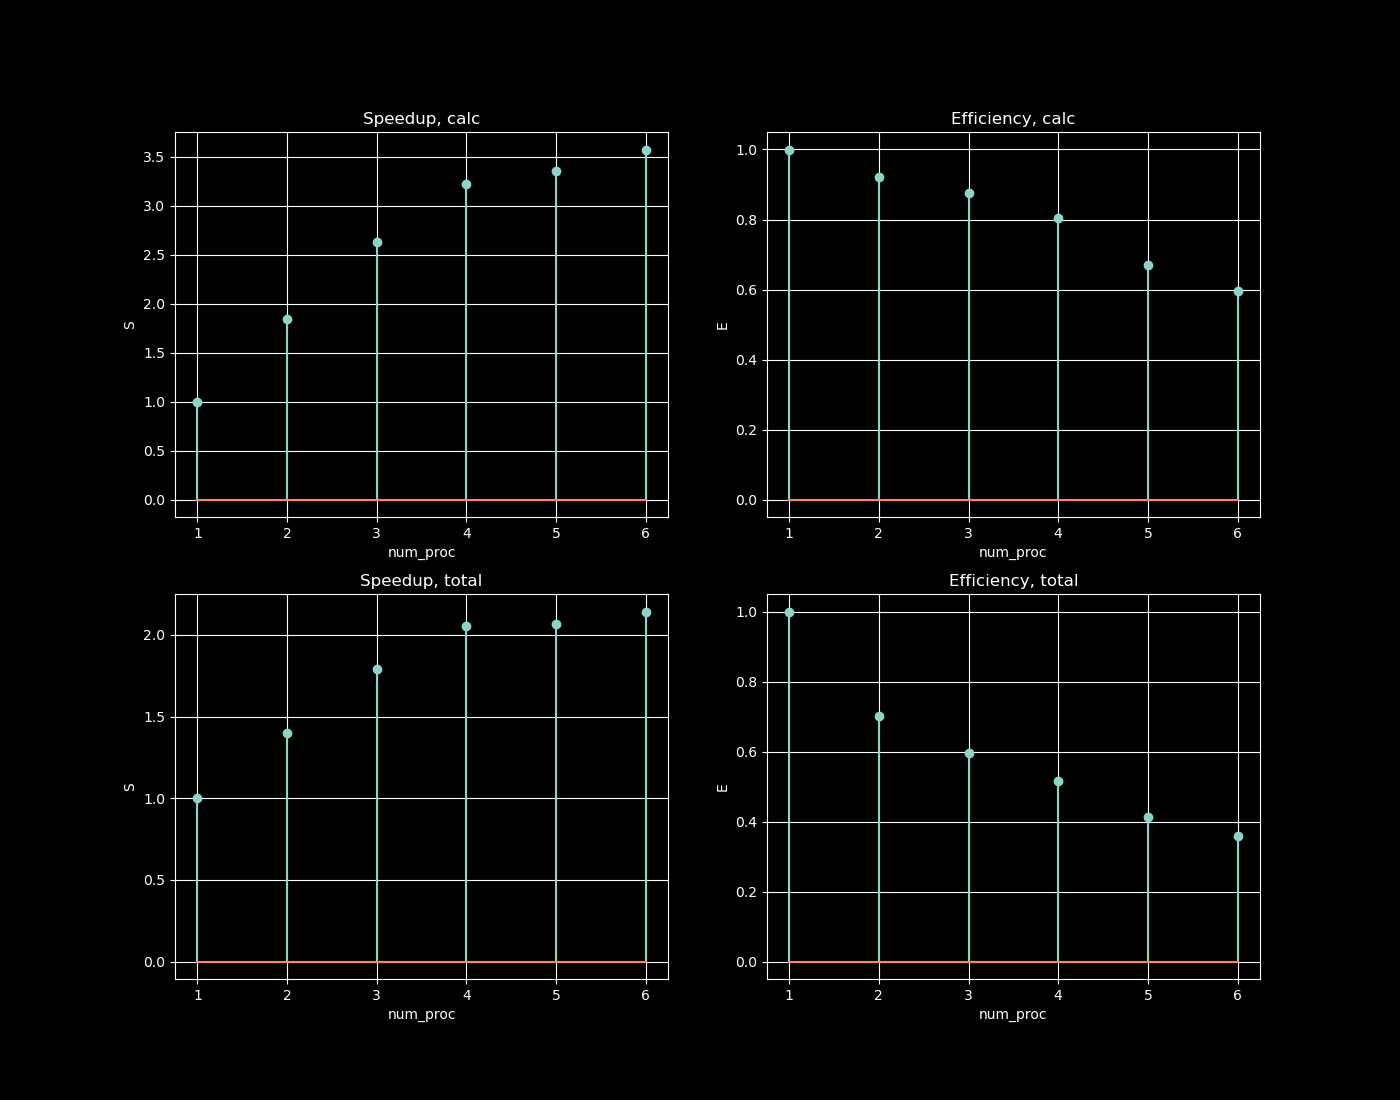

In [33]:
# Speedup & efficiency for calc
plt.figure (figsize = [14, 11])

plt.subplot (221)
plt.grid ()
plt.title ("Speedup, calc")
plt.xlabel ("num_proc")
plt.ylabel ("S")
plt.stem (np_var, times[0][0] / times[0])

E = times[0][0] / times[0]
for i in range (np_start, np_end + 1):
    E[i - np_start] = E[i - np_start] / i
plt.subplot (222)
plt.grid ()
plt.title ("Efficiency, calc")
plt.xlabel ("num_proc")
plt.ylabel ("E")
plt.stem (np_var, E)

plt.subplot (223)
plt.grid ()
plt.title ("Speedup, total")
plt.xlabel ("num_proc")
plt.ylabel ("S")
plt.stem (np_var, times[2][0] / times[2])

E = times[2][0] / times[2]
for i in range (np_start, np_end + 1):
    E[i - np_start] = E[i - np_start] / i
plt.subplot (224)
plt.grid ()
plt.title ("Efficiency, total")
plt.xlabel ("num_proc")
plt.ylabel ("E")
plt.stem (np_var, E)

make: Entering directory `/home/b0190302/lab1'
mpic++ "-std=c++11"  -o Lab1  main.cpp 
echo -e "\043PBS -l "walltime=00:01:00" \n\043PBS -N Lab1 \n\043PBS -q batch \ncd \044PBS_O_WORKDIR \nmpirun --hostfile \044PBS_NODEFILE "-np 4"  ./Lab1 512 512 5 10 0 512"	> job.sh 
make: Leaving directory `/home/b0190302/lab1'
make: Entering directory `/home/b0190302/lab1'
qsub -o stdout.txt ./job.sh 
155947.head.vdi.mipt.ru
make: Leaving directory `/home/b0190302/lab1'
  rank    calc time    gather time    total time
------  -----------  -------------  ------------
     0    0.0134721     0.00531197     0.297298
     1    0.013165      0.00273681     0.015923
     2    0.013401      0.00372314     0.017143
     3    0.0131662     0.00470901     0.0178909


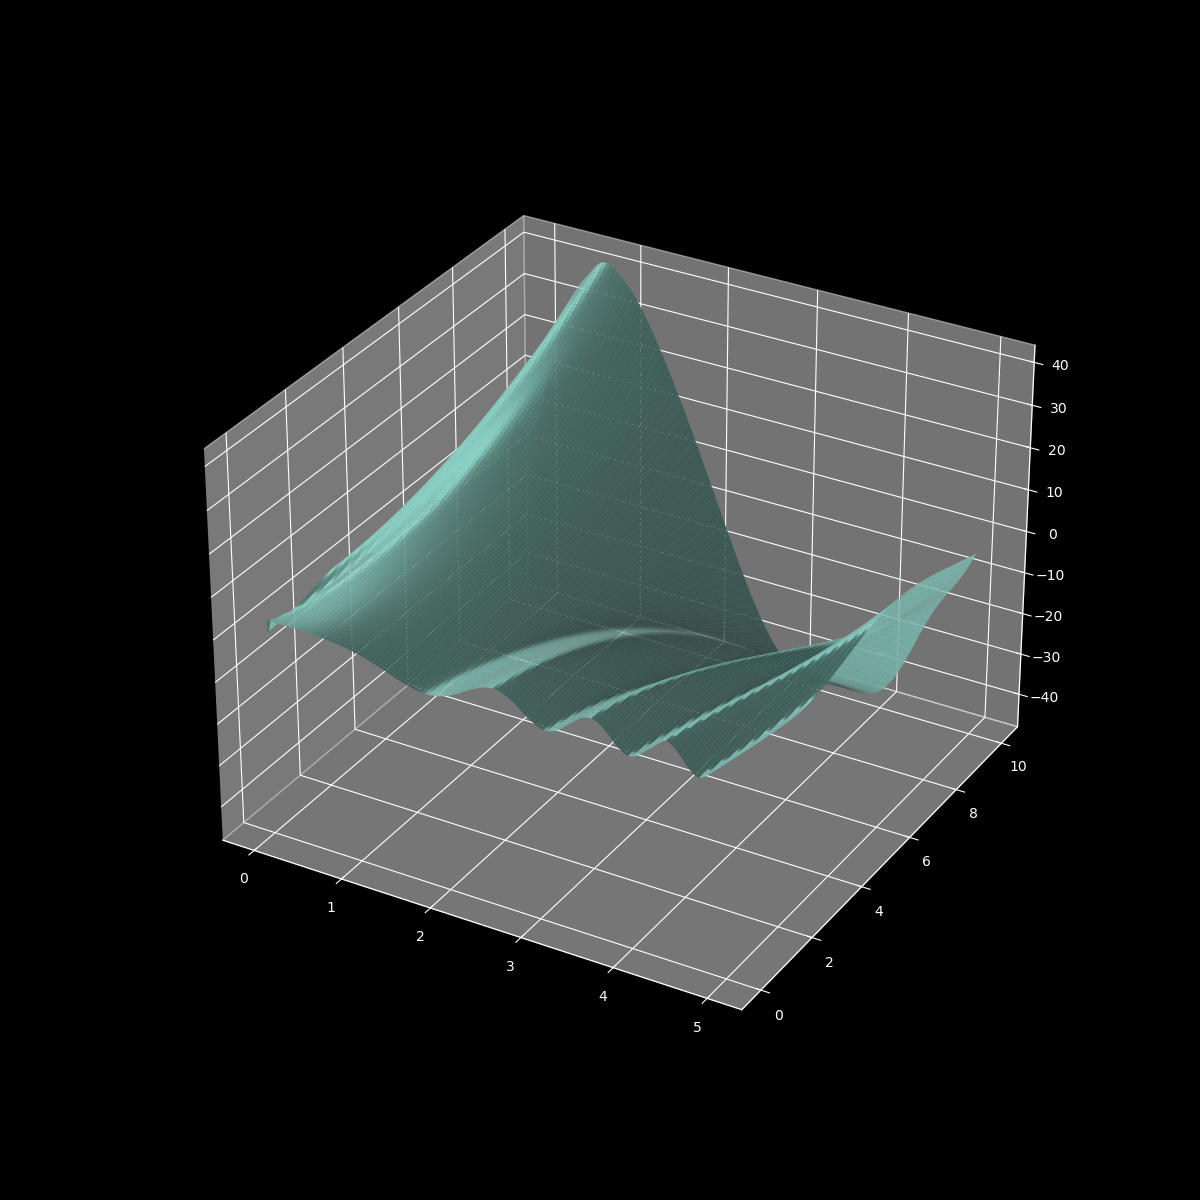

In [34]:
#### CLUSTER through ssh ####
import time
n_proc = 4
np_start = 1
np_end = 32

matrix = np.zeros ((x_points, x_points))
perf_ranks = np.zeros ((n_proc, 3))
compile = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "NUM_PROC={0}".format (n_proc), "ARGS=\"", "{0}".format (x_points), "{0}".format (t_points), "{0}".format (x_max), "{0}".format (t_max), "{0}".format (t_points - x_points), "{0}\"".format (t_points) , "-C", "./lab1/"])
#print (compile)
time.sleep (2)
run = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "-C", "./lab1/", "run"])
time.sleep (4)
result = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "cat", "./lab1/stdout.txt"], capture_output=True, text=True)
res_split = result.stdout.split ()
for i in range (0, x_points):
    for j in range (0, x_points):
        matrix[i][j] = res_split[i * x_points + j]
for i in range (0, n_proc):
    rank = res_split[x_points * x_points + i * 4]
    for j in range (0, 3):
        perf_ranks[int (rank)][j] = res_split[x_points * x_points + i * 4 + j + 1]
#print ("last layer :")
#print (matrix[x_points - 1])

tabledata = []
for i in range (0, n_proc):
    temp = []
    temp.append (i)
    temp.append (perf_ranks[i][0])
    temp.append (perf_ranks[i][1])
    temp.append (perf_ranks[i][2])
    tabledata.append (temp)
print (tabulate (tabledata, headers = ["rank", "calc time", "gather time", "total time"]))

X = np.outer (np.linspace (0, x_max, x_points), np.ones (x_points)).copy().T
T = np.outer (np.linspace (0, t_max, x_points), np.ones (x_points))
plt.figure(figsize=(12, 12))
plt.axes(projection ='3d').plot_surface (X, T, matrix, rcount = plt_rcount, ccount = plt_ccount)

100%|██████████| 25/25 [03:38<00:00,  8.73s/it]

  x_points    max calc time    max gather time    max total time
----------  ---------------  -----------------  ----------------
         6       0.00079298        0.000123024       0.000936985
      1006       0.00491881        0.00227284        0.00703502
      2006       0.0103929         0.00408411        0.014293
      3006       0.0142961         0.00615811        0.020083
      4006       0.0199261         0.00775981        0.0276458
      5006       0.0224171         0.0096581         0.032033
      6006       0.0250411         0.0115659         0.0365431
      7006       0.0291829         0.0137291         0.0424421
      8006       0.0386829         0.0157049         0.053952
      9006       0.0367801         0.0173731         0.0539789
     10006       0.0479822         0.0193119         0.0667241
     11006       0.049767          0.0212848         0.070292
     12006       0.049998          0.0230269         0.0725169
     13006       0.057986          0.0249591         

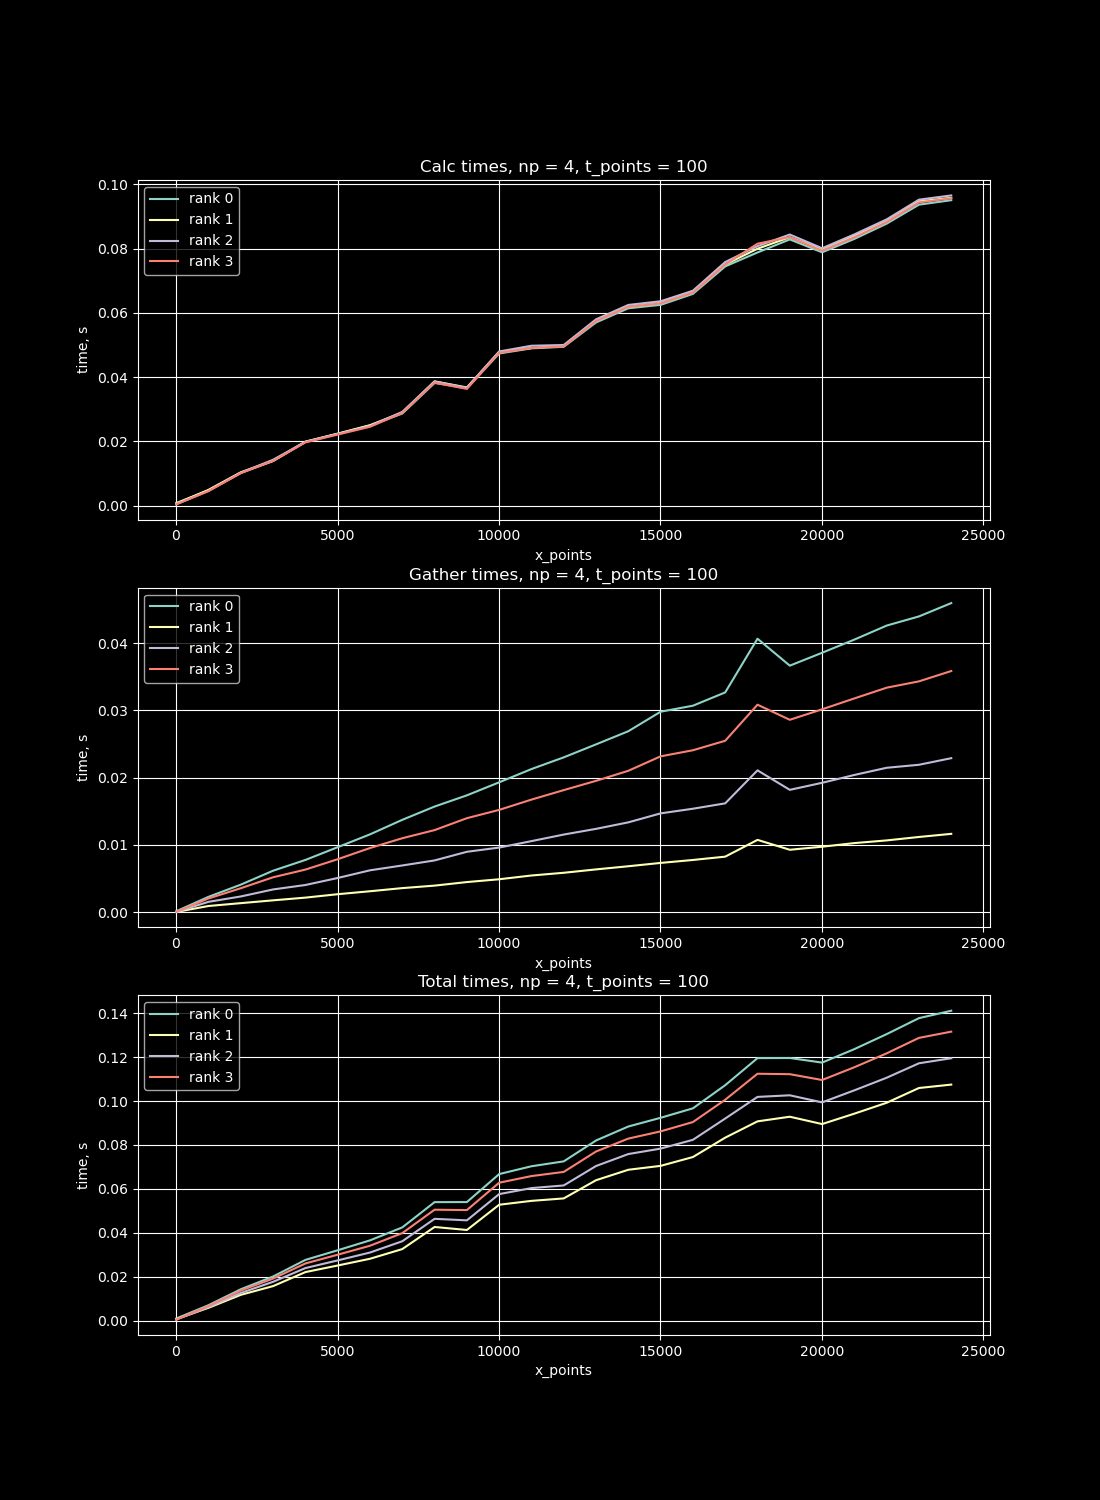

In [35]:
### x_points var at cluster

x_points_var = np.zeros (int ((x_points_end - x_points_start) / x_var_step) + 1)
times = np.zeros ((3, n_proc, int ((x_points_end - x_points_start) / x_var_step) + 1))
i = x_points_start
k = 0
tabledata = []
with tqdm(total=int ((x_points_end - x_points_start) / x_var_step) + 1) as pbar:
    while i < x_points_end:
        compile = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "NUM_PROC={0}".format (n_proc), "ARGS=\"", "{0}".format (i), "{0}".format (t_points_at_x_var), "{0}".format (x_max), "{0}".format (t_max), "n\"", "-C", "./lab1/"], capture_output=True)
        time.sleep (2)
        #print (compile)
        run = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "-C", "./lab1/", "run"], capture_output=True)
        time.sleep (4)
        result = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "cat", "./lab1/stdout.txt"], capture_output=True, text=True)
        #print (result)
        res_split = result.stdout.split ()
        times_max = np.zeros (3)
        for p in range (0, n_proc):
            rank = int (res_split[p * 4])
            for j in range (0, 3):
                times[j][rank][k] = res_split[p * 4 + j + 1]
                if times[j][rank][k] > times_max[j]:
                    times_max[j] = times[j][rank][k]
        x_points_var[k] = i
        temp = []
        temp.append (i)
        temp.append (times_max[0])
        temp.append (times_max[1])
        temp.append (times_max[2])
        tabledata.append (temp)
        i = i + x_var_step
        k = k + 1
        pbar.update (1)

print (tabulate (tabledata, headers = ["x_points", "max calc time", "max gather time", "max total time"]))

plt.figure (figsize = [11, 15])

plt.subplot (311)
plt.grid ()
plt.title ("Calc times, np = {0}, t_points = {1}".format(n_proc, t_points_at_x_var))
plt.xlabel ("x_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (x_points_var, times[0][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (312)
plt.grid ()
plt.title ("Gather times, np = {0}, t_points = {1}".format(n_proc, t_points_at_x_var))
plt.xlabel ("x_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (x_points_var, times[1][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (313)
plt.grid ()
plt.title ("Total times, np = {0}, t_points = {1}".format(n_proc, t_points_at_x_var))
plt.xlabel ("x_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (x_points_var, times[2][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

100%|██████████| 25/25 [03:24<00:00,  8.18s/it]

  t_points    max calc time    max gather time    max total time
----------  ---------------  -----------------  ----------------
        10      0.000478983        0.000128984       0.000633001
      1010      0.00660992         0.00236082        0.0089972
      2010      0.0132899          0.00428391        0.0176132
      3010      0.0189009          0.00634193        0.0251329
      4010      0.025275           0.00855398        0.0338681
      5010      0.0309598          0.0105209         0.0414779
      6010      0.0385189          0.012464          0.0510218
      7010      0.0434198          0.015379          0.05884
      8010      0.0493691          0.016891          0.0663049
      9010      0.0555398          0.0194221         0.075017
     10010      0.0609541          0.0217669         0.082777
     11010      0.068347           0.0238259         0.0922229
     12010      0.0734351          0.026221          0.0995641
     13010      0.0815032          0.0281088         

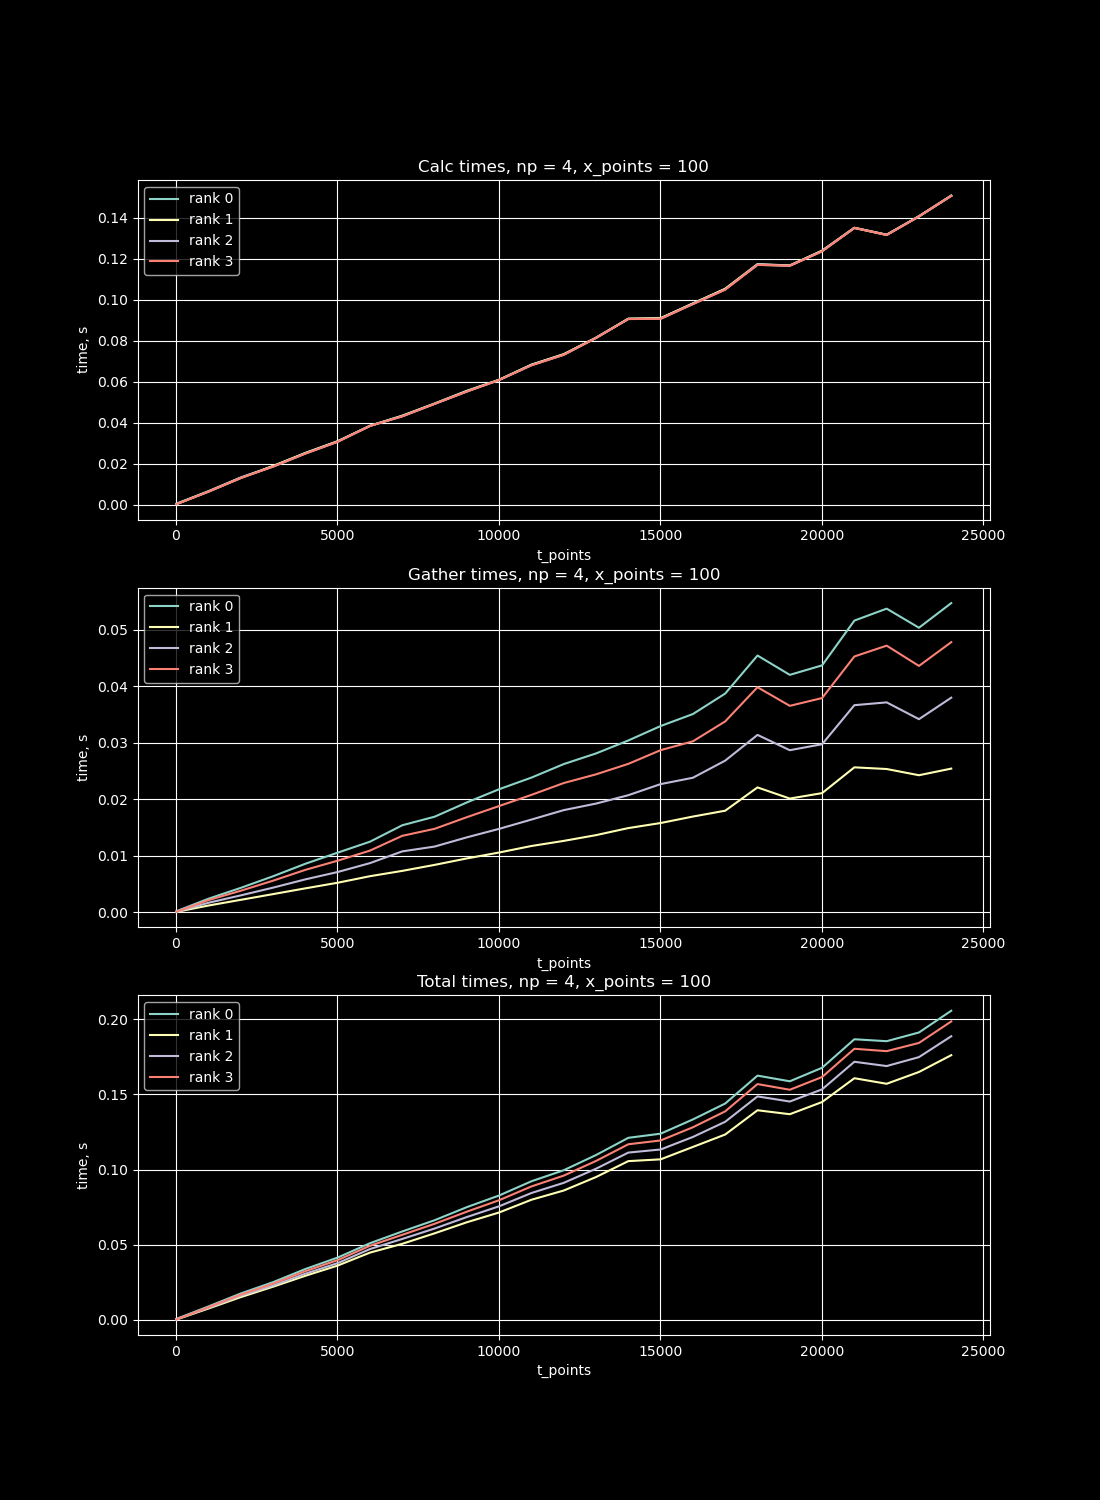

In [36]:
### t_points var at cluster

t_points_var = np.zeros (int ((t_points_end - t_points_start) / t_var_step) + 1)
times = np.zeros ((3, n_proc, int ((t_points_end - t_points_start) / t_var_step) + 1))
i = t_points_start
k = 0
tabledata = []
with tqdm(total=int ((t_points_end - t_points_start) / t_var_step) + 1) as pbar:
    while i < t_points_end:
        compile = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "NUM_PROC={0}".format (n_proc), "ARGS=\"", "{0}".format (x_points_at_t_var), "{0}".format (i), "{0}".format (x_max), "{0}".format (t_max), "n\"", "-C", "./lab1/"], capture_output=True)
        time.sleep (2)
        run = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "-C", "./lab1/", "run"], capture_output=True)
        time.sleep (4)
        result = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "cat", "./lab1/stdout.txt"], capture_output=True, text=True)
        res_split = result.stdout.split ()
        times_max = np.zeros (3)
        for p in range (0, n_proc):
            rank = int (res_split[p * 4])
            for j in range (0, 3):
                times[j][rank][k] = res_split[p * 4 + j + 1]
                if times[j][rank][k] > times_max[j]:
                    times_max[j] = times[j][rank][k]
        t_points_var[k] = i
        temp = []
        temp.append (i)
        temp.append (times_max[0])
        temp.append (times_max[1])
        temp.append (times_max[2])
        tabledata.append (temp)
        i = i + t_var_step
        k = k + 1
        pbar.update (1)

print (tabulate (tabledata, headers = ["t_points", "max calc time", "max gather time", "max total time"]))

plt.figure (figsize = [11, 15])

plt.subplot (311)
plt.grid ()
plt.title ("Calc times, np = {0}, x_points = {1}".format(n_proc, x_points_at_t_var))
plt.xlabel ("t_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (t_points_var, times[0][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (312)
plt.grid ()
plt.title ("Gather times, np = {0}, x_points = {1}".format(n_proc, x_points_at_t_var))
plt.xlabel ("t_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (t_points_var, times[1][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (313)
plt.grid ()
plt.title ("Total times, np = {0}, x_points = {1}".format(n_proc, x_points_at_t_var))
plt.xlabel ("t_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (t_points_var, times[2][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

100%|██████████| 16/16 [02:45<00:00, 10.35s/it]

  N proc    max calc time    max gather time    max total time
--------  ---------------  -----------------  ----------------
       1         2.35508            0                  2.35511
       2         1.50745            0.305542           1.81267
       3         0.998122           0.313425           1.31146
       4         0.700828           0.324271           1.02495
       5         1.35209            0.32725            1.67875
       6         1.03358            0.349518           1.38256
       7         1.17583            0.367629           1.54274
       8         1.11881            0.374073           1.49195
       9         1.06772            0.384765           1.45134
      10         1.22462            0.417249           1.64119
      11         1.28648            0.407616           1.69234
      12         1.79185            0.396272           2.18559
      13         2.35839            0.598838           2.95582
      14         1.67388            0.536139           

<StemContainer object of 3 artists>

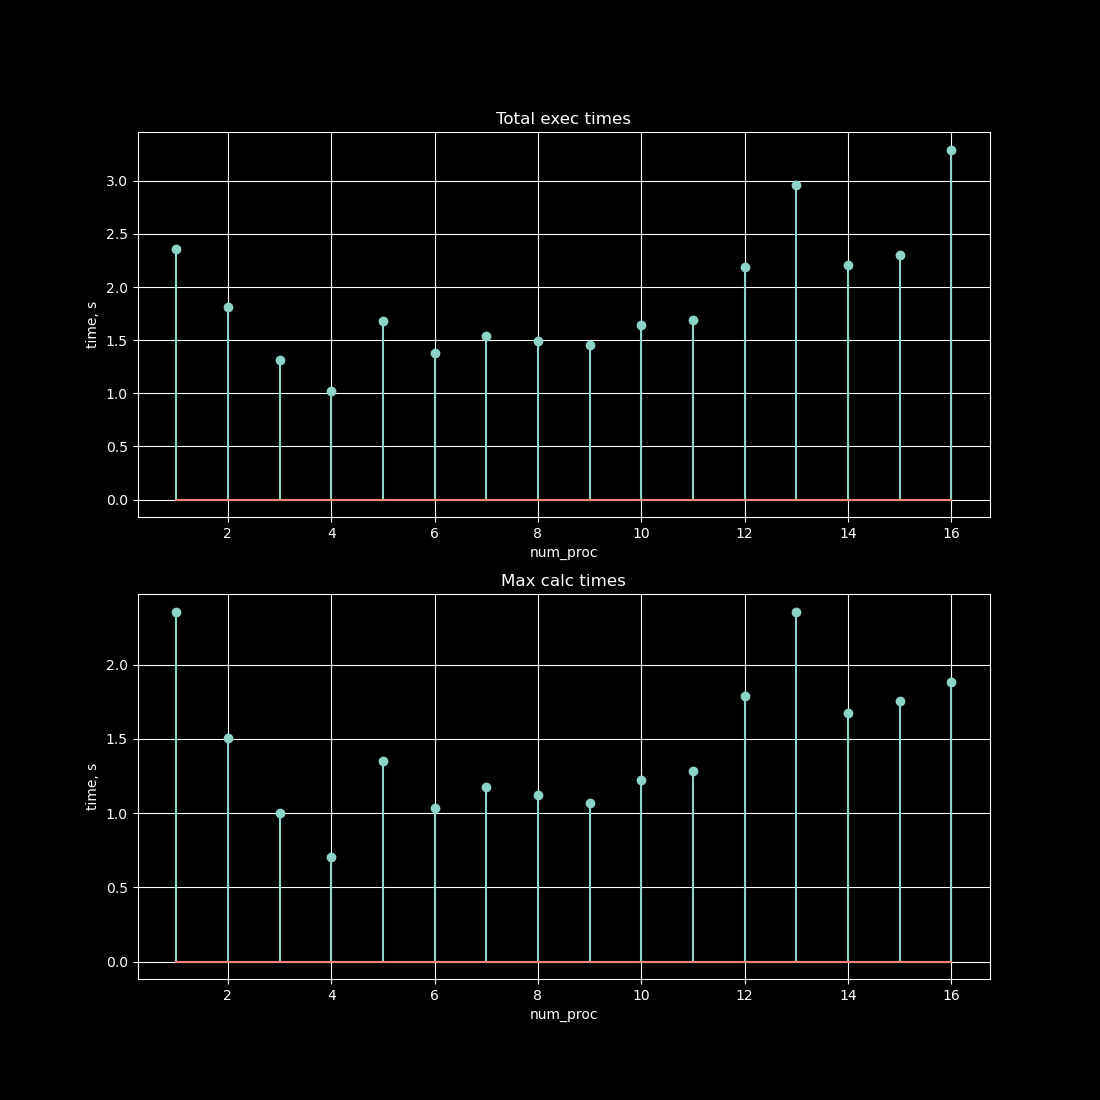

In [37]:
### np var at cluster
np_end = 16
np_var = np.arange (np_start, np_end + 1)
times = np.zeros ((3, np_end - np_start + 1))
i = np_start
tabledata = []
with tqdm(total = np_end - np_start + 1) as pbar:
    while i <= np_end: 
        compile = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "NUM_PROC={0}".format (i), "ARGS=\"", "{0}".format (x_points_at_np_var), "{0}".format (t_points_at_np_var), "{0}".format (x_max), "{0}".format (t_max), "n\"", "-C", "./lab1/"], capture_output=True)
        time.sleep (2)
        run = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "-C", "./lab1/", "run"], capture_output=True)
        time.sleep (6)
        result = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "cat", "./lab1/stdout.txt"], capture_output=True, text=True)
        res_split = result.stdout.split ()
        max_calc = 0
        max_gather = 0
        max_total = 0
        for p in range (0, i - np_start + 1):
            if float (res_split[p * 4 + 1]) > max_calc:
                max_calc = float (res_split[p * 4 + 1])
            if float (res_split[p * 4 + 2]) > max_gather:
                max_gather = float (res_split[p * 4 + 2])
            if float (res_split[p * 4 + 3]) > max_total:
                max_total = float (res_split[p * 4 + 3])

        times[0][i - np_start] = max_calc
        times[1][i - np_start] = max_gather
        times[2][i - np_start] = max_total
        temp = []
        temp.append (i)
        temp.append (max_calc)
        temp.append (max_gather)
        temp.append (max_total)
        tabledata.append (temp)
        i = i + 1
        pbar.update (1)

print (tabulate (tabledata, headers = ["N proc", "max calc time", "max gather time", "max total time"]))

plt.figure (figsize = [11, 11])

plt.subplot (211)
plt.grid ()
plt.title ("Total exec times")
plt.xlabel ("num_proc")
plt.ylabel ("time, s")
plt.stem (np_var, times[2])

plt.subplot (212)
plt.grid ()
plt.title ("Max calc times")
plt.xlabel ("num_proc")
plt.ylabel ("time, s")
plt.stem (np_var, times[0])

<StemContainer object of 3 artists>

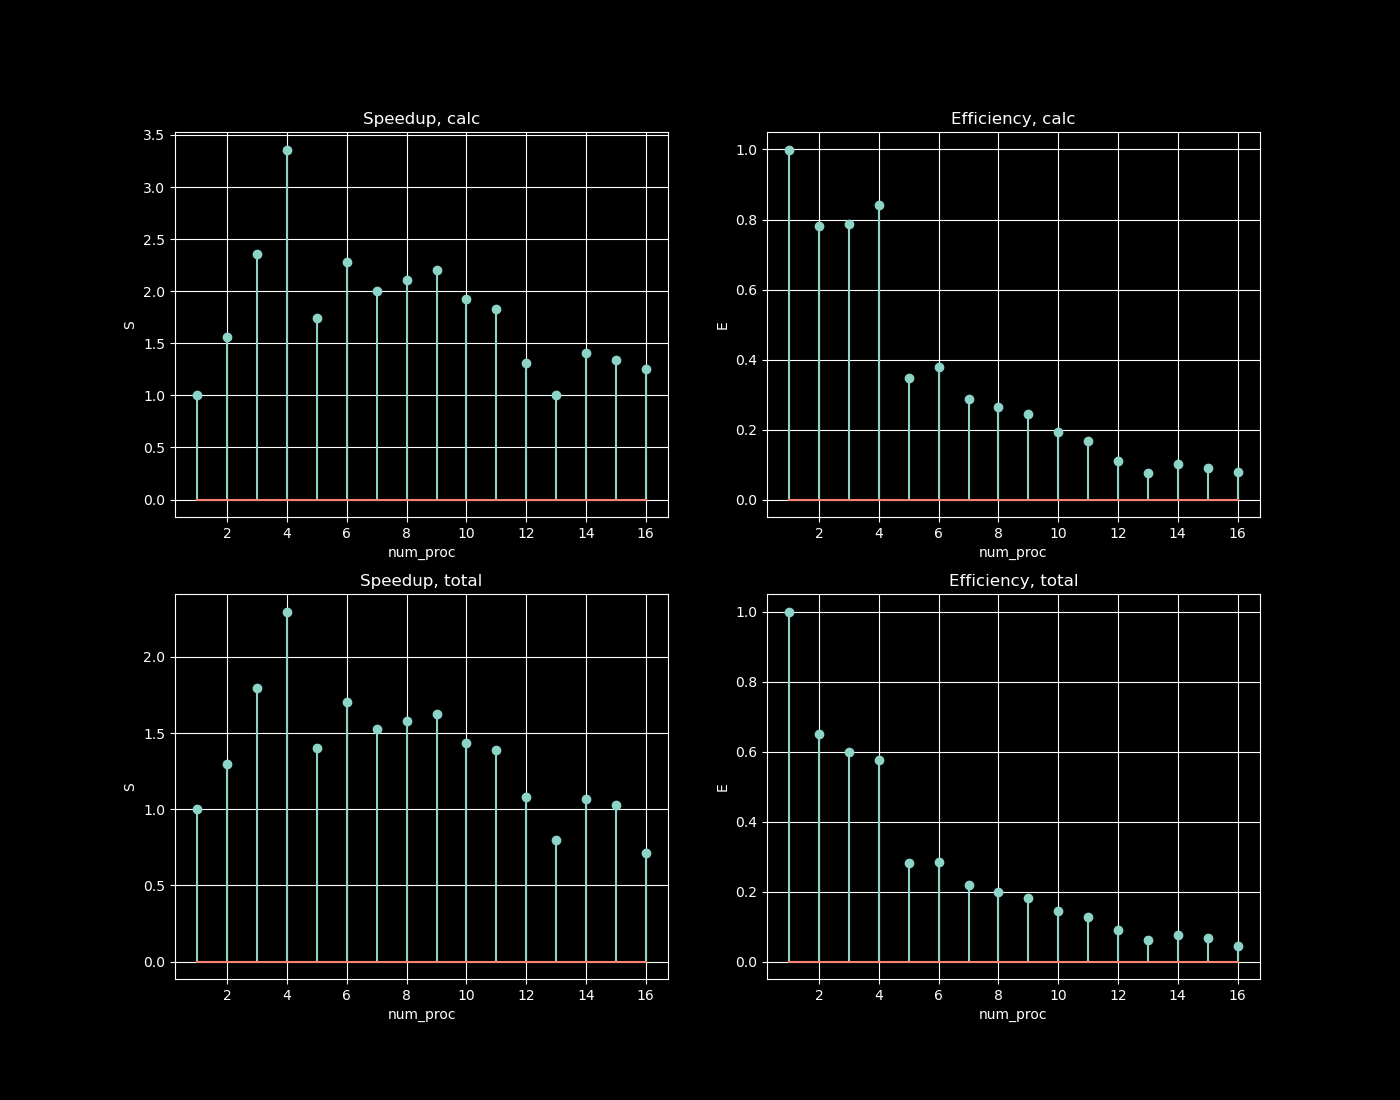

In [38]:
# Speedup & efficiency for calc
plt.figure (figsize = [14, 11])

plt.subplot (221)
plt.grid ()
plt.title ("Speedup, calc")
plt.xlabel ("num_proc")
plt.ylabel ("S")
plt.stem (np_var, times[0][0] / times[0])

E = times[0][0] / times[0]
for i in range (np_start, np_end + 1):
    E[i - np_start] = E[i - np_start] / i
plt.subplot (222)
plt.grid ()
plt.title ("Efficiency, calc")
plt.xlabel ("num_proc")
plt.ylabel ("E")
plt.stem (np_var, E)

plt.subplot (223)
plt.grid ()
plt.title ("Speedup, total")
plt.xlabel ("num_proc")
plt.ylabel ("S")
plt.stem (np_var, times[2][0] / times[2])

E = times[2][0] / times[2]
for i in range (np_start, np_end + 1):
    E[i - np_start] = E[i - np_start] / i
plt.subplot (224)
plt.grid ()
plt.title ("Efficiency, total")
plt.xlabel ("num_proc")
plt.ylabel ("E")
plt.stem (np_var, E)